<a href="https://colab.research.google.com/github/hjy530/CatsGreatAdventure/blob/main/prototype/RecommendationSystem/Python_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<추천 시스템>** 
<br> : 파이썬으로 개발하는 머신러닝

- 콘텐츠 기반 필터링
- 협업 기반 필터링
  - 최근접 이웃 협업 필터링
  - 잠재 요인 협업 필터링

사용한 파이썬 라이브러리
- Numpy(넘파이)
- Pandas(판다스)
- sklearn(사이킷런)

----------

- 데이터 로딩 및 가공
<br> 1. CSV 파일 가져오기 
<br> 2. 판다스 데이터프레임 : pd.read_csv()
<br> 3. 컬럼 추출 or 넘파이 배열(to.numpy()) 

In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

from IPython.display import Image # 깃허브 이미지 띄우기 : Image('https://user-images.githubusercontent.com/66590165/169763570-a498a343-48ad-4bcd-b844-e61109fdb0e2.jpg')
# Image(masterpiece.masterpiece_picture[0]) # 이미지 띄우기

user = pd.read_csv('https://raw.githubusercontent.com/hjy530/WOOYE/main/prototype/csv/user.csv', encoding='utf-8')
masterpiece = pd.read_csv('https://raw.githubusercontent.com/hjy530/WOOYE/main/prototype/csv/masterpiece.csv', encoding='utf-8')
grade = pd.read_csv('https://raw.githubusercontent.com/hjy530/WOOYE/main/prototype/csv/grade.csv', encoding='utf-8')

# user.head(2)
# masterpiece.head(2)
# grade.head(2)

df_user = user[['user_id','user_gender', 'user_age']]
df_masterpiece = masterpiece[['masterpiece_title', 'masterpiece_artist', 'masterpiece_era', 'masterpiece_year', 'masterpiece_technique', 'masterpiece_material']]
df_grade = grade[['user_id', 'masterpiece_seq', 'grade_score']]

df_masterpiece = df_masterpiece.astype({'masterpiece_year':'object'})
# df_masterpiece.dtypes

df_masterpiece.head(3)

,masterpiece_title,masterpiece_artist,masterpiece_era,masterpiece_year,masterpiece_technique,masterpiece_material
0,모나리자,레오나르도 다 빈치,르네상스,1503.0,인물화,유화
1,천지창조,미켈란젤로 부오나로티,르네상스,1512.0,종교화,벽화
2,최후의 만찬,레오나르도 다 빈치,르네상스,1490.0,종교화,벽화


----------

- 콘텐츠 기반 필터링
1. 두 가지(시대,기법) 칼럼 벡터화
<br> : 시대/기법를 기준으로 필터링할 경우 (즉, 유사한 시대/기법를 추천해주는 경우) 일단, 시대/기법들은 띄어쓰기가 구분된 한 문자열로 저장되어 있는데 이 문자열을 숫자로 바꿔서 벡터화 시켜야 한다.
2. 유사도 값 추출 (코사인 유사도)
<br> : 한 가지 칼럼이 아닌 두 가지 칼럼의 유사도 값을 구해 성능을 향상시킨다.
3. 명화 추천 사용자 함수 생성
<br> : 시대 기반의 유사도 -> 기법 기반의 유사도를 기준으로 영화를 추천해주는 사용자 함수를 정의한다.
4. 실행

+ 추가한 내용: 기존 프로젝트와 다르게 한 가지 칼럼이 아닌 두 가지 칼럼을 사용하여 벡터화하고 유사도를 구해 (명화 추천) 사용자 함수를 생성함

[기존 프로젝트 링크] https://pearlluck.tistory.com/666

In [ ]:
# 장르 벡터화

from sklearn.feature_extraction.text import CountVectorizer

countrt_vector = CountVectorizer(min_df=0, ngram_range=(1,2)) # 장르 or 기법 중 하나만 같으면 1, 둘 다 다르면 0, 두 개 다 같으면 2

c_vector_masterpiece_era = countrt_vector.fit_transform(df_masterpiece['masterpiece_era'])
c_vector_masterpiece_technique = countrt_vector.fit_transform(df_masterpiece['masterpiece_technique'])

# c_vector_masterpiece_era.shape
# c_vector_masterpiece_technique.shape

In [ ]:
# 유사도 값 추출 (코사인 유사도)

from sklearn.metrics.pairwise import cosine_similarity

similarity_masterpiece_era = cosine_similarity(c_vector_masterpiece_era, c_vector_masterpiece_era)
similarity_masterpiece_technique = cosine_similarity(c_vector_masterpiece_technique, c_vector_masterpiece_technique)
similarity_masterpiece_et = np.dot(similarity_masterpiece_technique ,similarity_masterpiece_era)

similarity_masterpiece_et[0]

array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.,
       3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1.])

In [ ]:
import numpy as np

# 명화 추천 사용자 함수 생성

def recommend_masterpiece_list(df, sim_matrix1, sim_matrix2, masterpiece_title, top=10):
  # 특정 명화 정보 뽑아내기
  target_masterpiece_index = df[df['masterpiece_title'] == masterpiece_title].index.values
  
  # 타겟 영화와 비슷한 코사인 유사도 값
  df["similarity1"] = sim_matrix1[target_masterpiece_index, :].reshape(-1, 1)
  df["similarity2"] = sim_matrix2[target_masterpiece_index, :].reshape(-1, 1)

  sim_index = df.sort_values(by=["similarity1",'similarity2'], ascending=False)

  # 본인 제외
  sim_index = sim_index[sim_index.index.values != target_masterpiece_index]

  # 유사도 내림차순 정렬 후 상위 index 추출
  final_index = sim_index.index.values[ : top]
  final_index = df.iloc[final_index].drop(['similarity1','similarity2'], axis = 1)
    
  return final_index

In [ ]:
# 명화 '모나리자'의 era는 르네상스, technique은 인물화
start = recommend_masterpiece_list(df_masterpiece, similarity_masterpiece_era, similarity_masterpiece_technique, '모나리자',10)
start

,masterpiece_title,masterpiece_artist,masterpiece_era,masterpiece_year,masterpiece_technique,masterpiece_material
1,천지창조,미켈란젤로 부오나로티,르네상스,1512.0,종교화,벽화
2,최후의 만찬,레오나르도 다 빈치,르네상스,1490.0,종교화,벽화
3,아테네 학당,라파엘로 산치오,르네상스,1510.0,상상화,벽화
4,최후의 심판,미켈란젤로 부오나로티,르네상스,1541.0,종교화,벽화
6,야경,렘브란트 하르먼손 반 레인,바로크,1642.0,인물화,유화
12,홀로페르네스를 죽이는 유디트,아르테미시아 젠틸레스키,바로크,1599.0,인물화,유화
13,그네,장 오노레 프라고나르,로코코,1767.0,인물화,유화
14,퐁파두르 후작부인,프랑수아 부셰,로코코,1756.0,인물화,유화
15,제르생의 간판,장 앙투안 와토,로코코,1720.0,인물화,유화
19,알프스를 넘는 나폴레옹,자크 루이 다비드,고전주의,1805.0,인물화,유화


----------

- 협업 기반 필터링 : 최근접 이웃 협업 필터링
  - 사용자-아이템 행렬에서 사용자가 아직 평가하지 않은 아이템을 예측함
  - 아이템 기반 협업 필터링: 행은 아이템, 열은 유저 행렬을 가지고 있는데, 아이템A와 아이템B가 비슷한 평점 분포를 가지고 있으면 비슷하다고 판단해서 유저에게 아이템A를 추천해준다.

[기존 프로젝트 링크] https://pearlluck.tistory.com/667

- 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np

df_masterpiece = masterpiece[['masterpiece_seq', 'masterpiece_title', 'masterpiece_artist', 'masterpiece_era', 'masterpiece_year', 'masterpiece_technique', 'masterpiece_material']]
# df_masterpiece.head()
# df_grade.head()

# masterpiece 데이터와 grade 데이터를 merge 함수를 이용하여 합침
user_masterpiece_score = pd.merge(df_masterpiece, df_grade, on="masterpiece_seq")
user_masterpiece_score.head()


,masterpiece_seq,masterpiece_title,masterpiece_artist,masterpiece_era,masterpiece_year,masterpiece_technique,masterpiece_material,user_id,grade_score
0,1,모나리자,레오나르도 다 빈치,르네상스,1503.0,인물화,유화,이소이,8
1,1,모나리자,레오나르도 다 빈치,르네상스,1503.0,인물화,유화,이루다,1
2,1,모나리자,레오나르도 다 빈치,르네상스,1503.0,인물화,유화,지사해,8
3,1,모나리자,레오나르도 다 빈치,르네상스,1503.0,인물화,유화,탁재영,4
4,1,모나리자,레오나르도 다 빈치,르네상스,1503.0,인물화,유화,김수연,6


- 피봇 테이블 생성과 NaN 처리
  - 사용자-명화에 따른 평점 점수가 데이터로 들어가야 한다.
  - masterpiece_user_score: 명화-사용자 피봇 테이블 (index: 명화, column: 사용자)
  - user_masterpiece_score: 사용자-명화 피봇 테이블 (index: 사용자, column: 명화)

In [ ]:
# 실행 전 (무조건) 전 코드 실행하기

masterpiece_user_score = user_masterpiece_score.pivot_table('grade_score', index='masterpiece_title', columns='user_id')
user_masterpiece_score = user_masterpiece_score.pivot_table('grade_score', index='user_id', columns='masterpiece_title')

# user_masterpiece_score.head()
masterpiece_user_score.head()

masterpiece_user_score.fillna(0, inplace=True)
masterpiece_user_score.head()

user_id,곽유진,김성연,김수연,남궁서윤,남리을,도민준,서희수,손지영,신아연,윤도윤,윤채연,이루다,이소이,장건우,정해준,지사해,최수현,탁재영,한지성,홍설희
masterpiece_title,,,,,,,,,,,,,,,,,,,,
4계절 연작화 : 겨울,2.0,1.0,3.0,10.0,5.0,5.0,0.0,8.0,0.0,2.0,0.0,4.0,0.0,5.0,0.0,10.0,1.0,0.0,3.0,0.0
거리의 신비와 우수,0.0,0.0,5.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,3.0,4.0,0.0,2.0,0.0,0.0,0.0,9.0,0.0,2.0
겨울 풍경,4.0,7.0,0.0,6.0,6.0,10.0,0.0,0.0,6.0,0.0,3.0,6.0,7.0,9.0,3.0,2.0,8.0,0.0,1.0,4.0
골콩드,6.0,2.0,0.0,3.0,4.0,0.0,0.0,0.0,2.0,1.0,0.0,7.0,0.0,2.0,0.0,9.0,2.0,0.0,3.0,8.0
과일 정물,7.0,0.0,5.0,0.0,9.0,0.0,4.0,0.0,7.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


- 유사도 값 추출 (코사인 유사도) 
- 유사도 값을 가진 데이터프레임 생성

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_rate = cosine_similarity(masterpiece_user_score, masterpiece_user_score)

similarity_rate_df = pd.DataFrame(
    data = similarity_rate,
    index = masterpiece_user_score.index,
    columns = masterpiece_user_score.index)

In [ ]:
similarity_rate_df.head()

masterpiece_title,4계절 연작화 : 겨울,거리의 신비와 우수,겨울 풍경,골콩드,과일 정물,그네,그랑드자트섬의 일요일 오후,금색 벨벳 천에 목련,기억의 지속,꽃공,...,차 안에서,천지창조,최후의 만찬,최후의 심판,캠벨 수프 통조림,파가니니의 초상,퐁파두르 후작부인,해바라기,호라티우스 형제의 맹세,홀로페르네스를 죽이는 유디트
masterpiece_title,,,,,,,,,,,,,,,,,,,,,
4계절 연작화 : 겨울,1.000000,0.156793,0.559682,0.624887,0.263618,0.438308,0.751727,0.452286,0.534337,0.385139,...,0.535799,0.574725,0.373232,0.473351,0.443303,0.667653,0.386185,0.533204,0.522347,0.472960
거리의 신비와 우수,0.156793,1.000000,0.158702,0.194259,0.361704,0.409943,0.436394,0.291328,0.447896,0.546220,...,0.370416,0.121780,0.515682,0.369163,0.333306,0.086312,0.212762,0.200450,0.480885,0.177031
겨울 풍경,0.559682,0.158702,1.000000,0.566291,0.443205,0.446019,0.469780,0.461546,0.544518,0.360407,...,0.537019,0.679536,0.583529,0.631228,0.427518,0.667808,0.714792,0.371227,0.411783,0.761864
골콩드,0.624887,0.194259,0.566291,1.000000,0.645640,0.410716,0.415715,0.518207,0.247175,0.364801,...,0.398307,0.526747,0.480144,0.627982,0.317512,0.490044,0.624586,0.416273,0.341385,0.296484
과일 정물,0.263618,0.361704,0.443205,0.645640,1.000000,0.392413,0.214388,0.413251,0.354059,0.475838,...,0.311597,0.194525,0.620930,0.375443,0.191020,0.163857,0.431596,0.161549,0.364796,0.276145


- 명화 추천 사용자 함수 생성

In [ ]:
# 가장 유사도가 높은 top 5
def recommand_masterpiece(masterpiece_title):
  return similarity_rate_df[masterpiece_title].sort_values(ascending=False)[:6]

In [ ]:
import pandas as pd

re_ma = pd.DataFrame(recommand_masterpiece("더 키스"))
re_ma

,더 키스
masterpiece_title,
더 키스,1.000000
최후의 심판,0.684716
절규,0.665440
인상 해돋이,0.664530
골콩드,0.643710
4계절 연작화 : 겨울,0.641129


----------

- 협업 기반 필터링 : 잠재 요인 협업 필터링
  - 행렬 분해를 기반으로 사용한다.
  - 사용자-아이템 행렬 데이터를 이용해 잠재요인을 찾아낸다. 즉, 사용자-아이템 행렬을 (사용자-잠재요인), (아이템-잠재요인) 행렬로 분해하는 것이다. -> 전체 사용자-아이템(행렬)에서 나온 값을 기반으로 잠재요인이 값을 매길 수 있게 되고, 이 값을 이용해서 사용자가 평가하지 않은 콘텐츠의 점수를 예측한다.

  - 장점: 잠재요인 필터링은 저장 공간을 (많이) 줄일 수 있다.

- 잠재 요인 협업 필터링을 기존 프로젝트 코드와 다르게 구현
  - 개인이 평점을 남긴 평점 데이터를 기반으로 해 새롭게 모든 명화의 예측 평점을 계산 한 후, 높은 예측 평점 중 개인이 평점을 부여하지 않은 명화만을 추천하는 방식을 사용하였다.
    - 'masterpiece_title'이 아닌 'user_id'를 사용해 명화를 추천한다.
  - 사용자가 평점을 매기지 않은 널 데이터가 많기 때문에 SVD(특이값 분해)가 아닌 SGD(확률적 경사 하강법)를 사용하였다.

[기존 프로젝트 링크] https://pearlluck.tistory.com/668

- 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np

df_masterpiece_test = masterpiece[['masterpiece_seq', 'masterpiece_title', 'masterpiece_artist', 'masterpiece_era', 'masterpiece_year', 'masterpiece_technique', 'masterpiece_material']]
df_grade_test = grade[['user_id', 'masterpiece_seq', 'grade_score']]
# df_masterpiece.head()
# df_grade.head()

potential_user_masterpiece_score = pd.merge(df_masterpiece_test, df_grade_test, on="masterpiece_seq")
# potential_user_masterpiece_score.drop('masterpiece_year', axis=1, inplace=True)
potential_user_masterpiece_score.shape

(600, 9)

- 피봇 테이블 생성과 NaN 처리

In [ ]:
user_masterpiece_matrix = potential_user_masterpiece_score.pivot_table('grade_score', index='user_id', columns='masterpiece_seq')
user_masterpiece_matrix = potential_user_masterpiece_score.pivot_table('grade_score', index='user_id', columns='masterpiece_title')
user_masterpiece_matrix.head()

user_masterpiece_matrix = user_masterpiece_matrix.fillna(0)
user_masterpiece_matrix.head()
# user_masterpiece_pivot.shape

masterpiece_title,4계절 연작화 : 겨울,거리의 신비와 우수,겨울 풍경,골콩드,과일 정물,그네,그랑드자트섬의 일요일 오후,금색 벨벳 천에 목련,기억의 지속,꽃공,...,차 안에서,천지창조,최후의 만찬,최후의 심판,캠벨 수프 통조림,파가니니의 초상,퐁파두르 후작부인,해바라기,호라티우스 형제의 맹세,홀로페르네스를 죽이는 유디트
user_id,,,,,,,,,,,,,,,,,,,,,
곽유진,2.0,0.0,4.0,6.0,7.0,7.0,0.0,0.0,2.0,0.0,...,0.0,7.0,9.0,7.0,0.0,0.0,1.0,0.0,0.0,2.0
김성연,1.0,0.0,7.0,2.0,0.0,6.0,0.0,4.0,3.0,0.0,...,5.0,0.0,4.0,10.0,3.0,6.0,4.0,0.0,0.0,2.0
김수연,3.0,5.0,0.0,0.0,5.0,0.0,3.0,6.0,3.0,7.0,...,8.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,9.0,0.0
남궁서윤,10.0,0.0,6.0,3.0,0.0,0.0,5.0,5.0,7.0,6.0,...,0.0,1.0,4.0,2.0,10.0,10.0,0.0,1.0,9.0,2.0
남리을,5.0,0.0,6.0,4.0,9.0,0.0,1.0,0.0,5.0,6.0,...,0.0,1.0,8.0,0.0,0.0,4.0,3.0,0.0,8.0,6.0


- 확률적 경사 하강법(SGD: Stochastic Gradient Descent)
  - 데이터를 미니 배치로 무작위로 선정하여 경사 하강법으로 매개변수를 갱신하는 방법으로 추출된 데이터 한 개의 대해서 그래디언트를 계산하고, 경사 하강 알고리즘을 적용한다.

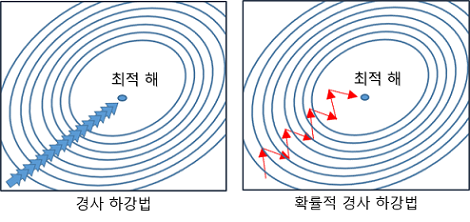

In [ ]:
Image("https://user-images.githubusercontent.com/50125047/170470715-560e52d7-0fa0-41db-9fbe-44aad0310df8.png")

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트. 
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

In [ ]:
P, Q = matrix_factorization(user_masterpiece_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  6.08267903502099
### iteration step :  10  rmse :  2.635138020513578
### iteration step :  20  rmse :  1.22957403745973
### iteration step :  30  rmse :  0.4839590454889882
### iteration step :  40  rmse :  0.2382553068493881
### iteration step :  50  rmse :  0.13442890550332792
### iteration step :  60  rmse :  0.08516799395290132
### iteration step :  70  rmse :  0.060167136220790826
### iteration step :  80  rmse :  0.047405865546581126
### iteration step :  90  rmse :  0.041003249690306894
### iteration step :  100  rmse :  0.037810853636395206
### iteration step :  110  rmse :  0.03618664515382985
### iteration step :  120  rmse :  0.03532167095403919
### iteration step :  130  rmse :  0.03482961974503076
### iteration step :  140  rmse :  0.03452590644275933
### iteration step :  150  rmse :  0.0343205104820634
### iteration step :  160  rmse :  0.034168220487795296
### iteration step :  170  rmse :  0.034045605151100056
### iteration step :  180 

In [ ]:
score_pred_matrix = pd.DataFrame(data=pred_matrix, index= user_masterpiece_matrix.index,
                                   columns = user_masterpiece_matrix.columns)

score_pred_matrix.head(3)

masterpiece_title,4계절 연작화 : 겨울,거리의 신비와 우수,겨울 풍경,골콩드,과일 정물,그네,그랑드자트섬의 일요일 오후,금색 벨벳 천에 목련,기억의 지속,꽃공,...,차 안에서,천지창조,최후의 만찬,최후의 심판,캠벨 수프 통조림,파가니니의 초상,퐁파두르 후작부인,해바라기,호라티우스 형제의 맹세,홀로페르네스를 죽이는 유디트
user_id,,,,,,,,,,,,,,,,,,,,,
곽유진,2.048185,4.007030,4.023325,5.973335,6.986173,6.967062,4.659918,3.524155,1.994882,8.143328,...,5.879328,6.963305,8.973775,6.998004,4.559820,4.974452,1.044094,5.715883,5.195512,2.018557
김성연,1.032658,4.296171,6.952591,2.024964,5.038835,5.949486,3.227771,4.026454,3.018610,3.928911,...,4.983439,5.880758,4.015141,9.924399,3.013776,5.960058,3.981304,5.291326,4.141627,2.011428
김수연,2.990753,4.996307,5.982195,2.807123,4.979400,3.510555,3.008039,6.040460,3.029308,6.981671,...,7.969329,4.302981,8.404905,5.984536,5.848071,5.801070,3.381307,7.618917,8.966605,5.202066


- 잠재요인 기반 협업 필터링
  - 사용자에게 아이템 기반 협업 필터링을 통해 이미 평점을 준 명화를 제외하고 추천할 수 있도록 평점을 주지 않은 명화를 리스트 객체로 반환하는 함수인 'get_unseen_masterpiece'를 생성한다.
  - 'recomm_masterpiece_by_userid' 함수는 예측 평점 DataFrame과 추천하려는 사용자id, 추천 후보 명화 리스트, 추천 상위 명화 개수를 인자로 받아서 사용자가 좋아할만한 가장 높은 예측 평점을 가진 명화를 추천해준다.   

In [ ]:
def get_unseen_masterpiece(user_masterpiece_matrix, user_Id):
    # user_Id로 입력받은 사용자의 모든 명화정보 추출하여 Series로 반환함. 
    # 반환된  user_masterpiece_score 은 명화명(masterpiece_title)을 index로 가지는 Series 객체임. 
    user_masterpiece_score = user_masterpiece_matrix.loc[user_Id,:]
    
    # user_masterpiece_score이 0보다 크면 기존에 관람한 명화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_masterpiece_score[user_masterpiece_score > 0].index.tolist()
    
    # 모든 명화명을 list 객체로 만듬. 
    masterpiece_list = user_masterpiece_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 masterpiece는 masterpiece_list에서 제외함. 
    unseen_list = [masterpiece for masterpiece in masterpiece_list if masterpiece not in already_seen]
    
    return unseen_list

In [ ]:
def recomm_masterpiece_by_userid(pred_df, user_Id, unseen_list, top=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 명화명 컬럼을 추출하여 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_masterpiece = pred_df.loc[user_Id, unseen_list].sort_values(ascending=False)[:top]
    return recomm_masterpiece

In [ ]:
# 사용자가 관람하지 않는 명화명 추출   
unseen_list = get_unseen_masterpiece(user_masterpiece_matrix, '이소이')

# 아이템 기반의 인접 이웃 협업 필터링으로 명화 추천 
recomm_masterpiece = recomm_masterpiece_by_userid(score_pred_matrix, '이소이', unseen_list, top=10)

# 평점 데이터를 DataFrame으로 생성. 
recomm_masterpiece = pd.DataFrame(data=recomm_masterpiece.values,index=recomm_masterpiece.index,columns=['pred_score'])
recomm_masterpiece

,pred_score
masterpiece_title,
호라티우스 형제의 맹세,8.955458
미델하르니스의 가로수길,8.942349
과일 정물,8.179007
사과 바구니,7.621845
어릿광대의 사육제,7.082678
최후의 만찬,6.756901
별이 빛나는 밤,6.547396
연인들,6.220250
거리의 신비와 우수,6.037501


----------